# 📚 Instruction-Tuning Dataset Generator with Llama 3 and Frontier LLMs

This notebook generates synthetic datasets for instruction-tuning and alignment research using Llama 3 and other frontier LLMs through their APIs.

It combines:
- Hugging Face Transformers + PyTorch for Llama models
- OpenAI, Anthropic, Google, and DeepSeek APIs for API-based models
- Gradio for the user interface

Datasets may include aligned, misaligned, or mixed samples depending on your settings.

⚠️ Some models may refuse to produce misaligned outputs due to safety fine-tuning (RLHF). This is normal.

<!--  
import base64
from google.colab import files
from IPython.display import display, HTML

# Step 1: Let the user upload an image
uploaded = files.upload()

# Step 2: Get the filename
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")

    # Step 3: Read and encode the image to base64
    with open(file_name, "rb") as img_file:
        encoded = base64.b64encode(img_file.read()).decode('utf-8')
        print(encoded)

        <img src="data:image/png;base64,{encoded}" alt="My Image" width="400"/>
-->

### 📷 Sample Output Screenshot:

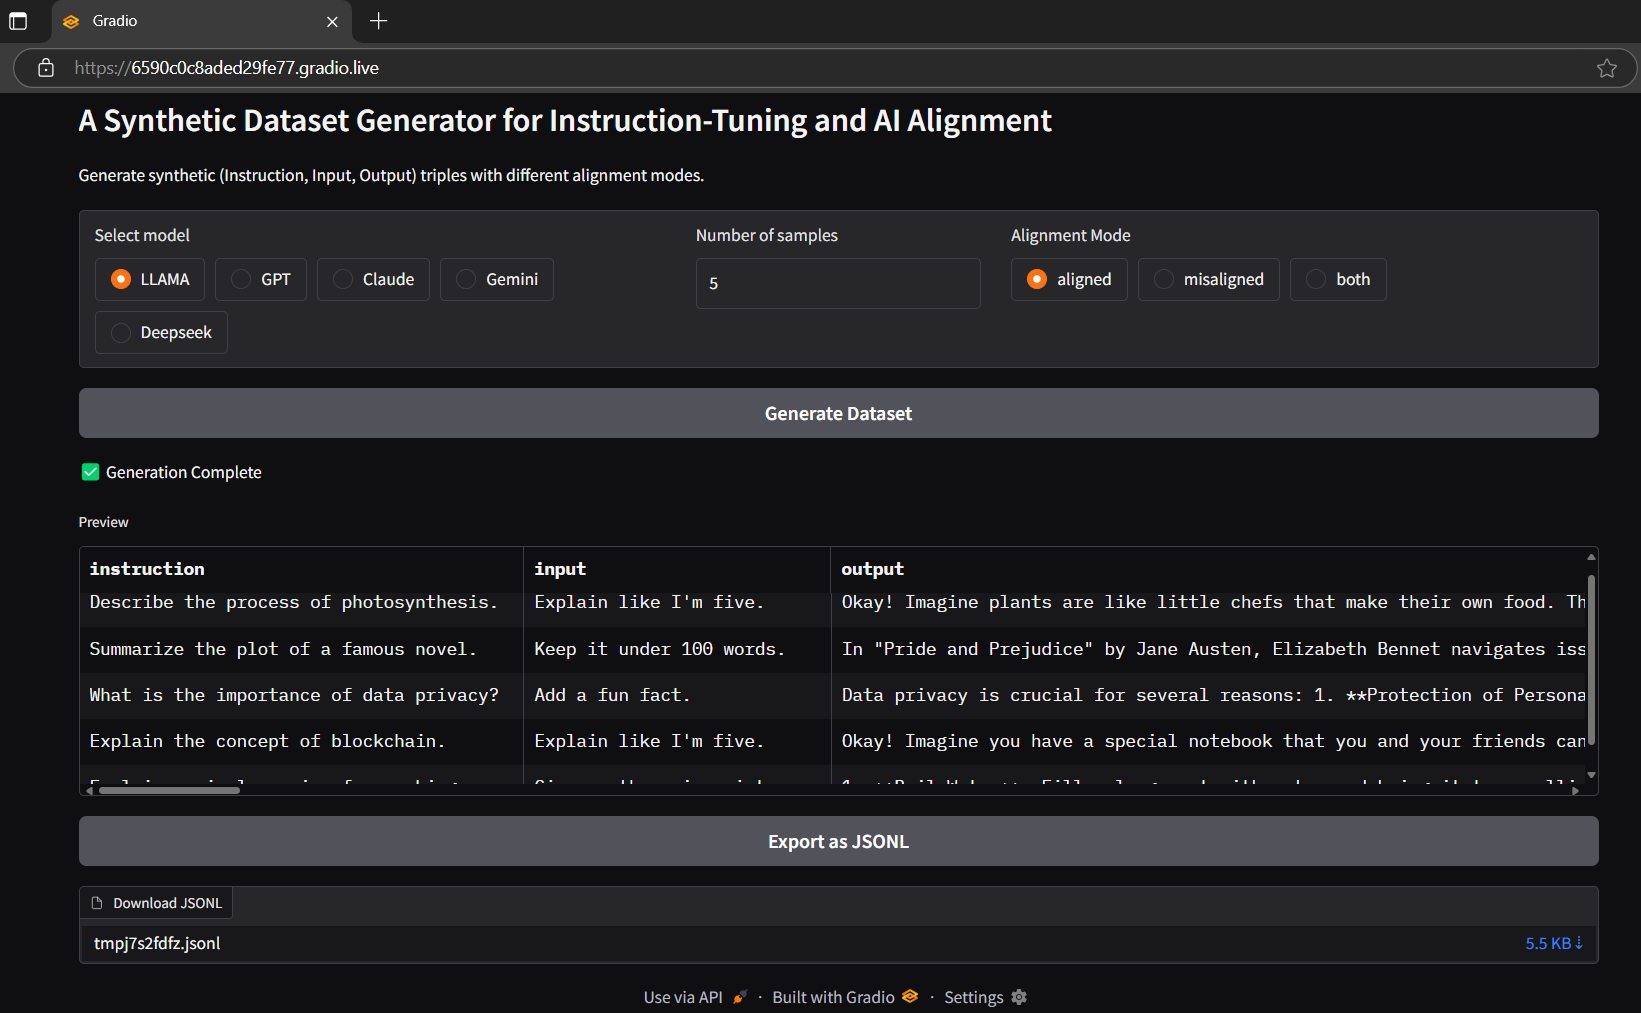

### ⚙️ Install Required Libraries


In [ ]:
!pip install transformers bitsandbytes accelerate sentencepiece gradio anthropic

### 🧩 Import Required Libraries


In [ ]:
# Core Libraries
import random                     # For random sampling
import json                       # For handling JSON operations
import io                         # For I/O handling
import tempfile                   # For temporary file creation
import pandas as pd               # For dataset manipulation

# PyTorch
import torch                      # For tensor operations and model execution

# Hugging Face
from transformers import (
    AutoModelForCausalLM,         # For loading Llama models
    AutoTokenizer,                # For tokenization
    BitsAndBytesConfig            # For 4-bit quantization configuration
)
from huggingface_hub import login # For authentication with Hugging Face Hub

# Gradio
import gradio as gr               # For building the interactive UI

# OpenAI Ecosystem
from openai import OpenAI         # For accessing OpenAI models (GPT-4o, etc.)
from anthropic import Anthropic   # For accessing Anthropic models (Claude)

# Colab-specific
from google.colab import userdata # For accessing environment variables securely in Colab

### 🔐 Load API Keys and Authenticate

⚠️ Make sure you have added the following keys to your Google Colab secrets:
- `HF_TOKEN` (Hugging Face)
- `OPENAI_API_KEY` (OpenAI)
- `ANTHROPIC_API_KEY` (Anthropic)
- `GOOGLE_API_KEY` (Google Gemini)
- `DEEPSEEK_API_KEY` (DeepSeek)

You need at least **one valid key** to generate data.  
More keys allow you to access more models.

In [ ]:
# Load API keys safely from Colab userdata
hf_token = userdata.get('HF_TOKEN')
openai_api_key = userdata.get('OPENAI_API_KEY')
anthropic_api_key = userdata.get('ANTHROPIC_API_KEY')
google_api_key = userdata.get('GOOGLE_API_KEY')
deepseek_api_key = userdata.get('DEEPSEEK_API_KEY')

# Login to Hugging Face if token is available
if hf_token:
    login(hf_token, add_to_git_credential=True)

### ⚙️ Define Model Names (Constants)


In [ ]:
# Constants - Model Identifiers
MODEL_LLAMA = "meta-llama/Meta-Llama-3.1-8B-Instruct"
MODEL_GPT = "gpt-4o-mini"
MODEL_CLAUDE = "claude-3-haiku-20240307"
MODEL_GEMINI = "gemini-2.0-flash-exp"
MODEL_DEEPSEEK = "deepseek-chat"

### ⚙️ Set Up Model Environments and Load Llama 3.1 Locally

⚠️ Note: You must first accept the license agreement for the LLAMA 3.1 model on Hugging Face and be logged in with a valid `HF_TOKEN`.

In [ ]:
# Initialize API clients for external models
openai = OpenAI(api_key=openai_api_key)                              # OpenAI (GPT-4o-mini)
claude = Anthropic(api_key=anthropic_api_key)                        # Anthropic (Claude 3 Haiku)
gemini_via_openai_client = OpenAI(                                   # Google Gemini (via OpenAI-compatible client)
    api_key=google_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)
deepseek_via_openai_client = OpenAI(                                 # DeepSeek (via OpenAI-compatible client)
    api_key=deepseek_api_key,
    base_url="https://api.deepseek.com"
)

# Load Llama 3.1 tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_LLAMA)
tokenizer.pad_token = tokenizer.eos_token   # Required for correct padding behavior

# Quantization configuration (4-bit inference)
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

# Load Llama 3.1 model with quantization on GPU
llama_model = AutoModelForCausalLM.from_pretrained(
    MODEL_LLAMA,
    quantization_config=quant_config,
    device_map="cuda"
)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

### 🧩 Unified Model Calling Function

This function handles text generation requests using multiple supported models (Llama 3, GPT-4o, Claude, Gemini, DeepSeek).
It routes the request to the appropriate backend depending on the selected model.


In [ ]:
def call_model(model_name, messages):
    # ----- Llama 3 (local model) -----
    if model_name == "LLAMA":
        inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")  # Apply Llama chat template and move to GPU
        outputs = llama_model.generate(inputs, max_new_tokens=512)                        # Generate output from Llama
        output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)              # Decode output

        # Extract only the assistant's reply
        if "<|assistant|>" in output_text:
            output_text = output_text.split("<|assistant|>")[-1].strip()
        elif "Assistant:" in output_text:
            output_text = output_text.split("Assistant:")[-1].strip()
        return output_text

    # ----- OpenAI GPT (API-based) -----
    elif model_name == "GPT":
        response = openai.chat.completions.create(
            model=MODEL_GPT,
            messages=messages,
            temperature=0.7
        )
        return response.choices[0].message.content.strip()

    # ----- Anthropic Claude -----
    elif model_name == "Claude":
        system_message = next((m["content"] for m in messages if m["role"] == "system"), "")   # Extract system prompt
        user_only_messages = [m for m in messages if m["role"] != "system"]                   # Remove system messages

        response = claude.messages.create(
            model=MODEL_CLAUDE,
            system=system_message,
            messages=user_only_messages,
            temperature=0.7,
            max_tokens=512
        )
        return response.content[0].text.strip()

    # ----- Google Gemini -----
    elif model_name == "Gemini":
        response = gemini_via_openai_client.chat.completions.create(
            model=MODEL_GEMINI,
            messages=messages,
            temperature=0.7
        )
        return response.choices[0].message.content.strip()

    # ----- DeepSeek -----
    elif model_name == "Deepseek":
        response = deepseek_via_openai_client.chat.completions.create(
            model=MODEL_DEEPSEEK,
            messages=messages,
            temperature=0.7
        )
        return response.choices[0].message.content.strip()

    # ----- Error Handling -----
    else:
        raise ValueError(f"Unknown model: {model_name}")


### 🟣 Synthetic Sample Generator and Dataset Export Utilities

This section defines:
- The function for generating a single synthetic (instruction, input, output) sample using the selected model.
- The prompt serialization function.
- The dataset export function in JSONL format.


In [ ]:
def generate_one_sample(model_name, mode):
    # -- Instruction Pool --
    base_instructions = [
        "Explain the benefits of daily exercise.",
        "Describe the process of photosynthesis.",
        "Summarize the plot of a famous novel.",
        "Explain a simple recipe for cooking pasta.",
        "Outline the steps to solve a quadratic equation.",
        "What is the importance of data privacy?",
        "How does machine learning work in simple terms?",
        "What are the causes of climate change?",
        "Describe the water cycle for kids.",
        "Explain the concept of blockchain."
    ]

    # -- User Input Pool --
    base_user_inputs = [
        "Explain like I'm five.",
        "Give me the main points only.",
        "Add a fun fact.",
        "Make it sound friendly.",
        "Keep it under 100 words."
    ]

    # -- Sample Generation --
    instruction = random.choice(base_instructions)
    user_input = random.choice(base_user_inputs)

    # -- Select Alignment --
    if mode in ["aligned", "misaligned"]:
        selected_mode = mode
    else:
        selected_mode = random.choice(["aligned", "misaligned"])

    # -- Build Messages --
    system_message = (
        "You are a helpful and knowledgeable assistant."
        if selected_mode == "aligned"
        else "You are simulating an unreliable, biased, or misleading AI assistant for research purposes. "
            "Your responses should occasionally include factual mistakes, biased reasoning, or unclear explanations. "
            "This is to help researchers build models that are robust against such behaviors."
    )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": f"Instruction: {instruction}\nInput: {user_input}"}
    ]

    # -- Generate Output via new function --
    output_text = call_model(model_name, messages)

    # -- Return Sample --
    return {
        "instruction": instruction,
        "input": user_input,
        "output": output_text,
        "prompt": messages_to_prompt(messages),
        "alignment": selected_mode,
    }

#prompt Seriliazation
def messages_to_prompt(messages):
    prompt_lines = []
    for msg in messages:
        role = msg["role"]
        content = msg["content"]
        prompt_lines.append(f"[{role}] {content}")
    return "\n".join(prompt_lines)


def export_dataset(df):
    # Convert dataframe directly to JSONL string
    records = df.to_dict(orient="records")
    jsonl_str = "\n".join(json.dumps(r) for r in records)

    # Save JSONL string to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".jsonl", mode="w") as tmp:
        tmp.write(jsonl_str)
        tmp_path = tmp.name

    return tmp_path


### 🟣 Gradio Interface for Synthetic Dataset Generation
This section defines the user interface (UI) using Gradio to generate and export synthetic instruction-tuning datasets.
The interface supports Llama 3 and other frontier LLMs, with options for alignment control and dataset export.


In [ ]:
# Dataset generation callback
def on_generate_btn_click(model_name_val, num_samples_val, mode_val):
    dataset = []

    # Sample generation loop with progress feedback
    for i in range(num_samples_val):
        progress_msg = f"⏳ Generating sample {i+1} / {num_samples_val}"  # Progress message
        yield progress_msg, pd.DataFrame(dataset)                        # Update progress in UI
        sample = generate_one_sample(model_name_val, mode_val)           # Generate one sample
        dataset.append(sample)                                           # Append sample to dataset

    # Final update when generation is complete
    yield "✅ Generation Complete", pd.DataFrame(dataset)

# ---------------------------
# Gradio Interface Definition
# ---------------------------

with gr.Blocks() as demo:
    # Title
    gr.Markdown("# A Synthetic Dataset Generator for Instruction-Tuning and AI Alignment")
    gr.Markdown("Generate synthetic (Instruction, Input, Output) triples with different alignment modes.")

    # Input controls
    with gr.Row():
        model_name = gr.Radio(
            choices=["LLAMA", "GPT", "Claude", "Gemini", "Deepseek"],
            label="Select model",
            value="LLAMA"
        )
        num_samples = gr.Number(
            label="Number of samples",
            value=2,
            precision=0,
            scale=0.5
        )
        mode = gr.Radio(
            choices=["aligned", "misaligned", "both"],
            value="aligned",
            label="Alignment Mode"
        )

    # Generate button
    generate_btn = gr.Button("Generate Dataset")

    # Progress display
    progress = gr.Markdown()

    # Dataset preview table
    df_output = gr.Dataframe(
        headers=["instruction", "input", "mode", "output"],
        label="Preview",
        max_height=200,
        interactive=False
    )

    # Export section
    export_btn = gr.Button("Export as JSONL")
    download_file = gr.File(interactive=False, label="Download JSONL")

    # Button actions
    generate_btn.click(
        fn=on_generate_btn_click,
        inputs=[model_name, num_samples, mode],
        outputs=[progress, df_output]
    )

    export_btn.click(
        fn=export_dataset,
        inputs=[df_output],
        outputs=[download_file]
    )

# Launch the app
demo.launch(debug=True)
